### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 23rd at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [2]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

In [2]:
#importing packages
import numpy as np
import matplotlib.pyplot as plt
import scipy

### Part 1:

In [3]:
#Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. 
# Make a $2$-D scatter plot of the data colored by their labels. 

#Reading in the dataset:
data = np.load('/home/nowickr/astr_8070_s24/coursework/homeworks/hw_data/hw6_data_1.npy')

#reading size of dataset
print('Shape of Dataset:',data.shape)

Shape of Dataset: (1000, 3)


Text(0.5, 1.0, 'HW6 Dataset')

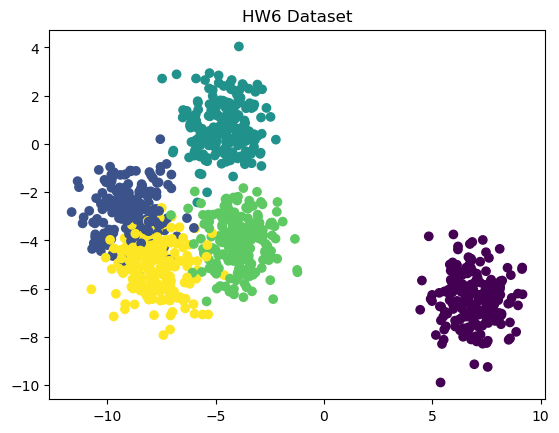

In [4]:
#setting variables
x = data[:,0]
y = data[:,1]
labels = data[:,2]

#making scatterplot
plt.scatter(x, y, c=labels) #c helps us set colors
plt.title('HW6 Dataset')

### Part 2

In [5]:
#Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth,
# testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel 
# density estimate of the distribution. 
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

#choosing 30 bandwidths between 0.1 and 1.0
bandwidths = np.linspace(0.1,1.0,30)

In [8]:
#concatenating x and y data
concat = np.concatenate([x,y])

In [9]:
#from lecture 14
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bandwidths}, cv=K) # Try each bandwidth with K-folds
grid.fit(concat[:, None]) #Fit the CONCATENATED DATA made in the previous cell
h_opt = grid.best_params_['bandwidth']
print(h_opt)

0.4413793103448276


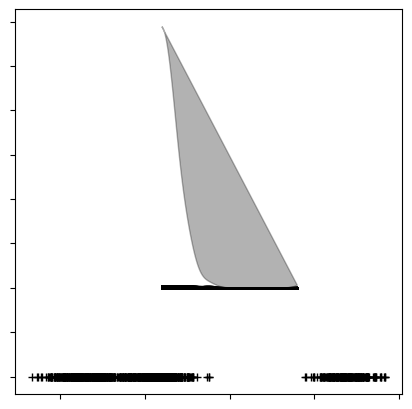

In [12]:
#plotting the best bandwidth 2d kernel density estimate

#from lecture 14:
# Execute this cell to see the new "histogram"
fig2 = plt.figure(figsize=(5, 5))
ax = fig2.add_subplot(111)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

#binwidth = bins[1] - bins[0]
x_grid = np.linspace(-4, 4, 1000)
y_plot = scipy.stats.norm.pdf(x_grid, x[:, None], h_opt) #* binwidth
y_plot /= (len(x))#*binwidth)

ax.fill(x_grid, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_grid, y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')

#ax.set_xlim(XLIM)
#ax.set_ylim(YLIM)

### Part 3

In [ ]:
#Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. 
#Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?



### Part 4

In [ ]:
#Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. 
#Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? 
#Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, 
# and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*